In [1]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import re
import numpy as np

In [2]:
def performance_data(perf_path):
  output = dict()
  f = open(perf_path.joinpath("performance.log"),"r")
  lines = f.readlines()
  escape_force = False
  nmax = len(lines)
  n = 0
  Big_category = re.compile("Total elapsed time for (.*): *([0-9.,]*) s")
  mpi_all = re.compile("All-to-many operations:")
  cpu = re.compile("Calculation time summary:")
  while n < nmax and not escape_force:
    line = lines[n]
    cat = re.match(Big_category,line)
    if cat:
      Name = cat.groups()[0]
      output[Name] = dict()
      output[Name]["Time_tot"] = float(cat.groups()[1])
      if re.search("gradient",Name):
        n += 2
        line = lines[n]
        grad = re.search("Summary of gradient computations for \"(.*)\"",line)
        while grad and n < nmax:
          name_grad = grad.groups()[0]
          output[Name][name_grad] = dict()
          n += 2
          line = lines[n]
          reconstruct = re.search("Reconstruction type: *(.*)",line)
          if reconstruct:
            output[Name][name_grad]["Reconstruct"] = reconstruct.groups()[0]
          n += 1
          line = lines[n]
          ncalls = re.search("Number of calls: *(\d*)",line)
          if ncalls:
            output[Name][name_grad]["Ncalls"] = int(ncalls.groups()[0])
          n += 1
          line = lines[n]
          time_grad = re.search("Total elapsed time: *([0-9,.]*)",line)
          if time_grad:
            output[Name][name_grad]["Time_grad"] = float(time_grad.groups()[0])
          n += 2
          line = lines[n]
          grad = re.search("Summary of gradient computations for \"(.*)\"",line)
      if re.search("system solvers",Name):
        n += 5
        line = lines[n]
        solv = re.search("Summary of resolutions for \"(.*)\"",line)
        while solv and n<nmax:
          name_solv = solv.groups()[0]
          output[Name][name_solv] = dict()
          n += 2
          line = lines[n]
          var = re.search("Solver type: *(.*)",line)
          if var:
            output[Name][name_solv]["Solver"] = var.groups()[0]
            n += 1
          line = lines[n]
          var = re.search("Preconditioning: *(.*)",line)
          if var:
            output[Name][name_solv]["Preconditioning"] = var.groups()[0]
            n += 1
          line = lines[n]
          var = re.search("Number of setups: *(\d*)",line)
          if var:
            output[Name][name_solv]["Nb_Setup"] = int(var.groups()[0])
            n += 1
          line = lines[n]
          var = re.search("Number of calls: *(\d*)",line)
          if var:
            output[Name][name_solv]["Nb_calls"] = int(var.groups()[0])
            n += 1
          line = lines[n]
          var = re.search("Minimum number of iterations: *(\d*)",line)
          if var:
            output[Name][name_solv]["MinNbIter"] = int(var.groups()[0])
            n += 1
          line = lines[n]
          var = re.search("Maximum number of iterations: *(\d*)",line)
          if var:
            output[Name][name_solv]["MaxNbIter"] = int(var.groups()[0])
            n += 1
          line = lines[n]
          var = re.search("Mean number of iterations: *(\d*)",line)
          if var:
            output[Name][name_solv]["MeanNbIter"] = int(var.groups()[0])
            n += 1
          line = lines[n]
          var = re.search("Total setup time: *([0-9.,]*)",line)
          if var:
            output[Name][name_solv]["TimeSetup"] = float(var.groups()[0])
            n += 1
          line = lines[n]
          var = re.search("Total solution time: *([0-9.,]*)",line)
          if var:
            output[Name][name_solv]["TimeSol"] = float(var.groups()[0])
            n += 1
          line = lines[n]
          solv = re.search("Summary of resolutions for \"(.*)\"",line)
          escape = re.search("------",line)
          while not solv and not escape:
            n += 1
            line = lines[n]
            solv = re.search("Summary of resolutions for \"(.*)\"",line)
            escape = re.search("------",line)
    
    mpi = re.match(mpi_all,line)
    if mpi:
      n +=3
      line = lines[n]
      mpi_data = re.search("Total: *([0-9,.]*) s *([0-9,.]*)  *([0-9,.]*) s *([0-9,.]*)",line)
      output["mpi"] = dict()
      output["mpi"]["mean"] = float(mpi_data.groups()[0])
      output["mpi"]["min"] = float(mpi_data.groups()[1])
      output["mpi"]["max"] = float(mpi_data.groups()[2])
      output["mpi"]["calls"] = int(mpi_data.groups()[3])
    cpu_perf = re.match(cpu,line)
    if cpu_perf:
      Name = "CPU"
      output[Name]=dict()
      n += 2
      line = lines[n]
      var = re.search("User CPU time: *([0-9,.]*) s",line)
      if var:
        output[Name]["User_cpu_time"] = float(var.groups()[0])
      n += 1
      line = lines[n]
      var = re.search("System CPU time: *([0-9,.]*) s",line)
      if var:
        output[Name]["System_cpu_time"] = float(var.groups()[0])
      n += 1
      line = lines[n]
      var = re.search("Total CPU time: *([0-9,.]*) s",line)
      if var:
        output[Name]["Total_cpu_time"] = float(var.groups()[0])
      n += 2
      line = lines[n]
      var = re.search("Elapsed time: *([0-9,.]*) s",line)
      if var:
        output[Name]["Elapsed_time"] = float(var.groups()[0])
      n += 1
      line = lines[n]
      var = re.search("CPU \/ elapsed time *([0-9,.]*)",line)
      if var:
        output[Name]["Ratio_time"] = float(var.groups()[0])
    n+=1
  return output

In [3]:
dico = performance_data(Path("/media/juleslecoustre/Jules/TJunction/STRUCT_SKE/STRUCT_SKE_24ms"))

<AxesSubplot:>

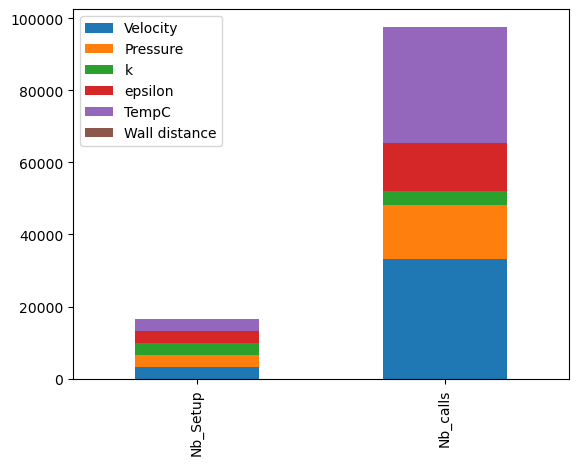

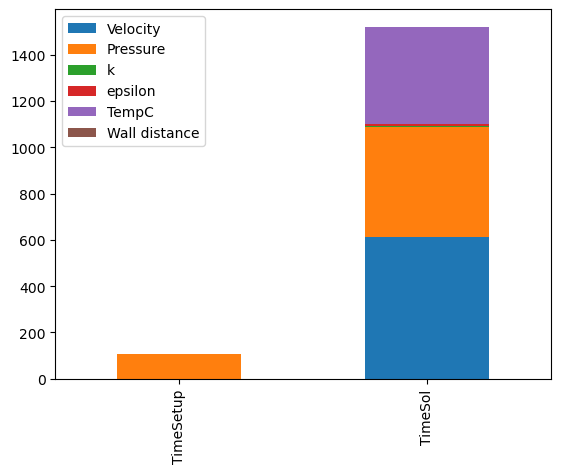

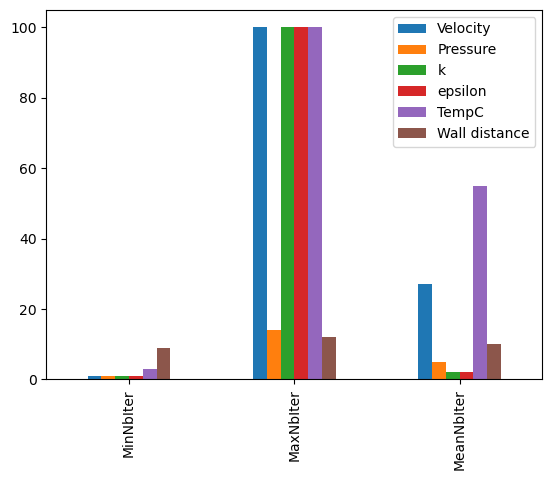

In [21]:
df = pd.DataFrame.from_dict(dico['linear equation system solvers'])
Time_tot = dico['linear equation system solvers']["Time_tot"]
df = df.drop(columns="Time_tot")
df = df.drop(["Solver","Preconditioning"])


df1 = df.loc[['Nb_Setup', 'Nb_calls']]
df3 = df.loc[['MinNbIter', 'MaxNbIter', 'MeanNbIter']]
df2 = df.loc[['TimeSetup', 'TimeSol']]
df1.plot.bar(stacked=True)
df2.plot.bar(stacked=True)
df3.plot.bar()

In [29]:
df_grad = pd.DataFrame.from_dict(dico['all gradient computations'])
df_grad = df_grad.drop(columns="Time_tot")

<AxesSubplot:>

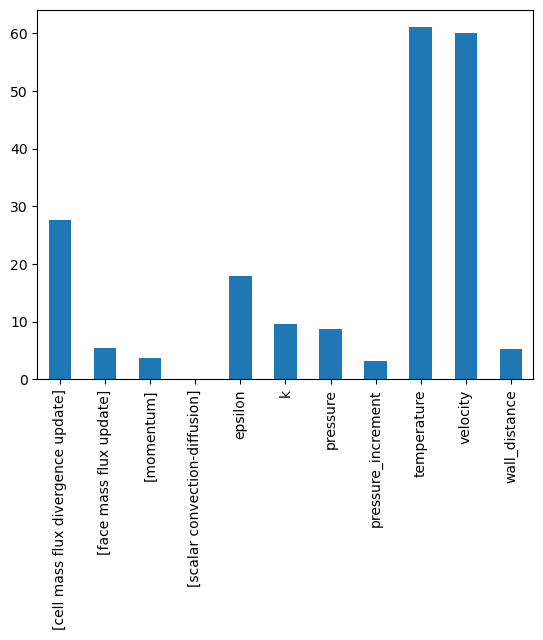

In [30]:
df_grad.loc["Time_grad"].plot.bar()

In [35]:
a = {"CPU":dico['CPU']}
pd.DataFrame.from_dict(a)

,CPU
Elapsed_time,3112.180
Ratio_time,0.908
System_cpu_time,696.694
Total_cpu_time,558952.741
User_cpu_time,2128.878


In [37]:
b = {"MPI":dico['mpi']}
pd.DataFrame.from_dict(b)

,MPI
calls,3181.00000
max,31.33631
mean,26.96184
min,16.06579
